<a href="https://colab.research.google.com/github/kodai-utsunomiya/memorization-and-generalization/blob/main/Organizing_memories_for_generalization_in_complementary_learning_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt


class TSN():

    def __init__(self, input_dim, output_dim, P, P_test, SNR, lr = 0.05, rand_seed = 101):
        self.N = input_dim
        self.output_dim = output_dim
        self.P = P
        self.P_test = P_test
        self.variance_w = snr_to_var(SNR)[0]
        self.variance_e = snr_to_var(SNR)[1]
        self.lr = lr
        torch.manual_seed(rand_seed)
        noise_train = torch.normal(0, self.variance_e**0.5, size = [self.P,1])
        noise_test = torch.normal(0, self.variance_e**0.5, size = [self.P_test,1])
        W_t = torch.normal(0, self.variance_w**0.5, size=(self.N, 1))
        self.train_x = torch.normal(0, (1/self.N)**0.5, size=(self.P, self.N))
        self.train_y = torch.matmul(self.train_x, W_t) + noise_train
        self.test_x = torch.normal(0, (1/self.N)**0.5, size=(self.P_test, self.N))
        self.test_y = torch.matmul(self.test_x, W_t) + noise_test

    def training_loop(self, nepoch = 1000, reg_strength = 0):

        model = nn.Sequential(nn.Linear(self.N,self.output_dim,bias=False))
        optimizer = optim.SGD(model.parameters(), lr=self.lr*(self.N/2), weight_decay = reg_strength) # to match the learnrate in the matlab implementation.
        optimizer.zero_grad()

        with torch.no_grad():
             list(model.parameters())[0].zero_()

        Et = np.zeros((nepoch,1))
        Eg = np.zeros((nepoch,1))
        print_iter = 200

        for i in range(nepoch):
            optimizer.zero_grad()
            train_error = criterion(self.train_y, model(self.train_x))
            train_error.backward()
            optimizer.step()
            Et[i] = train_error.detach().numpy()
            with torch.no_grad():
                 test_error = criterion(self.test_y, model(self.test_x))
                 Eg[i] = test_error.numpy()
            # if i%print_iter == 0:
            #    print('Et '+ str(Et[i].item()),'Eg '+ str(Eg[i].item()),str(i*100/nepoch) + '% Finished')

        return Et, Eg

class TSN_validation():

    def __init__(self, input_dim, output_dim, P, P_test, SNR, lr = 0.05, rand_seed = 101):
        self.N = input_dim
        self.output_dim = output_dim
        self.P = P
        self.P_test = P_test
        self.variance_w = snr_to_var(SNR)[0]
        self.variance_e = snr_to_var(SNR)[1]
        self.lr = 0.05
        torch.manual_seed(rand_seed)
        noise_train = torch.normal(0, self.variance_e**0.5, size = [self.P,1])
        noise_test = torch.normal(0, self.variance_e**0.5, size = [self.P_test,1])
        W_t = torch.normal(0, self.variance_w**0.5, size=(self.N, 1))
        self.train_x = torch.normal(0, (1/self.N)**0.5, size=(self.P, self.N))
        self.train_y = torch.matmul(self.train_x, W_t) + noise_train
        self.test_x = torch.normal(0, (1/self.N)**0.5, size=(self.P_test, self.N))
        self.test_y = torch.matmul(self.test_x, W_t) + noise_test

    def training_loop(self, nepoch = 2000, reg_strength = 1e-2):

        model = nn.Sequential(nn.Linear(self.N,self.output_dim,bias=False))
        optimizer = optim.SGD(model.parameters(), lr=self.lr*(self.N/2), weight_decay= reg_strength) # to match the learnrate in the matlab implementation.
        optimizer.zero_grad()

        with torch.no_grad():
             list(model.parameters())[0].zero_()

        Et = np.zeros((nepoch,1))
        Eg = np.zeros((nepoch,1))
        print_iter = 200

        for i in range(nepoch):
            optimizer.zero_grad()
            train_error = criterion(self.train_y, model(self.train_x))
            train_error.backward()
            optimizer.step()
            Et[i] = train_error.detach().numpy()
            with torch.no_grad():
                 test_error = criterion(self.test_y, model(self.test_x))
                 Eg[i] = test_error.numpy()
            # if i%print_iter == 0:
            #    print('Et '+ str(Et[i].item()),'Eg '+ str(Eg[i].item()),str(i*100/nepoch) + '% Finished')

        return Et, Eg

def snr_to_var(SNR):
    if SNR == np.inf:
        variance_w = 1
        variance_e = 0
    else:
        variance_w = SNR/(SNR + 1)
        variance_e = 1/(SNR + 1)
    return variance_w, variance_e

def criterion(y, y_hat):
    return (y - y_hat).pow(2).mean()

Run 1/5
Generating offline training data from notebook reactivations...
Epoch 0/200
Epoch 10/200
Epoch 20/200
Epoch 30/200
Epoch 40/200
Epoch 50/200
Epoch 60/200
Epoch 70/200
Epoch 80/200
Epoch 90/200
Epoch 100/200
Epoch 110/200
Epoch 120/200
Epoch 130/200
Epoch 140/200
Epoch 150/200
Epoch 160/200
Epoch 170/200
Epoch 180/200
Epoch 190/200
Calculating training and test errors mediated by notebook...
Starting Training...
Epoch 0/200
Epoch 10/200
Epoch 20/200
Epoch 30/200
Epoch 40/200
Epoch 50/200
Epoch 60/200
Epoch 70/200
Epoch 80/200
Epoch 90/200
Epoch 100/200
Epoch 110/200
Epoch 120/200
Epoch 130/200
Epoch 140/200
Epoch 150/200
Epoch 160/200
Epoch 170/200
Epoch 180/200
Epoch 190/200
Run 2/5
Generating offline training data from notebook reactivations...
Epoch 0/200
Epoch 10/200
Epoch 20/200
Epoch 30/200
Epoch 40/200
Epoch 50/200
Epoch 60/200
Epoch 70/200
Epoch 80/200
Epoch 90/200
Epoch 100/200
Epoch 110/200
Epoch 120/200
Epoch 130/200
Epoch 140/200
Epoch 150/200
Epoch 160/200
Epoch 170

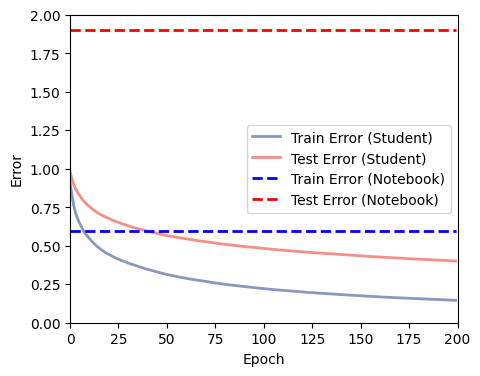

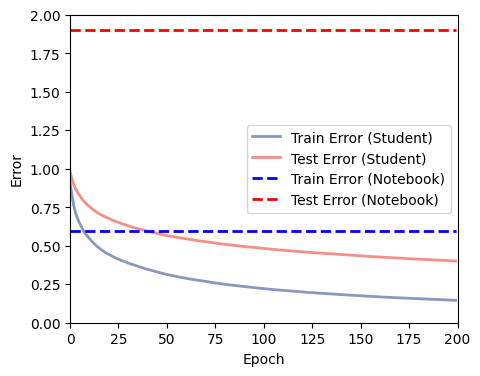

In [39]:
# Main code for Student-Teacher-Notebook framework

import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import SGD
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Parameters
r_n = 5  # number of repeats
nepoch = 200
learnrate = 0.015
N_x_t = 100  # teacher input dimension
N_y_t = 1  # teacher output dimension
P = 100  # number of training examples
P_test = 1000  # number of testing examples


# According to SNR, set variances for teacher's weights (variance_w) and output noise (variance_e) that sum to 1
SNR = float('inf')
variance_w = 1 if SNR == float('inf') else SNR / (SNR + 1)
variance_e = 0 if SNR == float('inf') else 1 / (SNR + 1)

# Student and teacher share the same dimensions
N_x_s = N_x_t
N_y_s = N_y_t

# Notebook parameters
# see Buhmann, Divko, and Schulten, 1989 for details regarding gamma and U terms
M = 200  # number of units in notebook
a = 0.05  # notebook sparseness
gamma = 0.6  # inhibition parameter
U = -0.15  # threshold for unit activation
ncycle = 9  # number of recurrent cycles

# Metrices for storing train error, test error, reactivation error (driven by notebook)
# Without early stopping
train_error_all = np.zeros((r_n, nepoch)) # student train error
test_error_all = np.zeros((r_n, nepoch)) # student test error
N_train_error_all = np.zeros((r_n, nepoch)) # notebook train error
N_test_error_all = np.zeros((r_n, nepoch)) # notebook test error

# With early stopping
train_error_early_stop_all = np.zeros((r_n, nepoch))
test_error_early_stop_all = np.zeros((r_n, nepoch))

# Run simulation for r_n times
for r in range(r_n):
    print(f'Run {r + 1}/{r_n}')
    torch.manual_seed(r)  # set random seed for reproducibility

    # Initialize error vectors
    error_train_vector = np.zeros(nepoch)
    error_test_vector = np.zeros(nepoch)
    error_react_vector = np.zeros(nepoch)

    # Teacher Network
    W_t = torch.normal(0, variance_w**0.5, size=(N_x_t, N_y_t)) # set teacher's weights with variance_w
    noise_train = torch.normal(0, variance_e**0.5, size=(P, N_y_t)) # set the variance for label noise
    # Training data
    x_t_input = torch.normal(0, (1/N_x_t)**0.5, size=(P, N_x_t)) # inputs
    y_t_output = x_t_input @ W_t + noise_train # outputs

    # Testing data
    noise_test = torch.normal(0, variance_e**0.5, size=(P_test, N_y_t))
    x_t_input_test = torch.normal(0, (1/N_x_t)**0.5, size=(P_test, N_x_t))
    y_t_output_test = x_t_input_test @ W_t + noise_test

    # Notebook Network
    # Generate P random binary indices (0 or 1) with sparseness a
    N_patterns = torch.zeros(P, M, dtype=torch.bool)
    for n in range(P):
        N_patterns[n, torch.randperm(M)[:int(M*a)]] = 1

    # Hebbian learning for notebook recurrent weights
    W_N = (N_patterns.float() - a).T @ (N_patterns.float() - a) / (M * a * (1 - a))
    W_N = W_N - gamma / (a * M)  # add global inhibiton term, see Buhmann, Divko, and Schulten, 1989
    W_N.fill_diagonal_(0) # no self connection


    # Hebbian learning for Notebook-Student weights (bidirectional)

    # Notebook to student weights, for reactivating student
    W_N_S_Lin = (N_patterns.float() - a).T @ x_t_input / (M * a * (1 - a))
    W_N_S_Lout = (N_patterns.float() - a).T @ y_t_output / (M * a * (1 - a))
    # Student to notebook weights, for providing partial cues
    W_S_N_Lin = x_t_input.T @ (N_patterns.float() - a)
    W_S_N_Lout = y_t_output.T @ (N_patterns.float() - a)

    # Student Network
    W_s = torch.normal(0, 0**0.5, size=(N_x_s, N_y_s)) # set students weights, with zero weight initialization

    # Generate offline training data from notebook reactivations
    N_patterns_reactivated = torch.zeros(P, M, nepoch, dtype=torch.bool) # array for storing retrieved notebook patterns, pre-calculating all epochs for speed considerations

    print("Generating offline training data from notebook reactivations...")
    for m in range(nepoch):
        if m % 10 == 0:  # Progress every 10 epochs
            print(f"Epoch {m}/{nepoch}")
        # Notebook pattern completion through recurrent dynamis
        # % Code below simulates hippocampal offline spontanenous
        # % reactivations by seeding the initial notebook state with a random
        # % binary pattern, then notebook goes through a two-step retrieval
        # % process: (1) Retrieving a pattern using dynamic threshold to
        # % ensure a pattern with sparseness a is retrieved (otherwise a silent
        # % attractor will dominate retrieval). (2) Using the
        # % retrieved pattern from (1) to seed a second round of pattern
        # % completion using a fixed-threshold method (along with a global
        # % inhibition term during encoding), so the retrieved patterns are
        # % not forced to have a fixed sparseness, in addition, there is a
        # % "silent  state" attractor when the seeding pattern lies far away
        # % from any of the encoded patterns.

        # Start recurrent cycles with dynamic threshold
        Activity_dyn_t = torch.zeros(P, M, dtype=torch.float32)

        # First round of pattern completion through recurrent activtion cycles given
        # random initial input.
        for cycle in range(ncycle):
            if cycle <= 1:
                clamp = 1
            else:
                clamp = 0
            rand_patt = torch.rand(P, M) <= a # random seeding activity
            # Seeding notebook with random patterns
            M_input = Activity_dyn_t + (rand_patt.float() * clamp)
            # Seeding notebook with original patterns
            # M_input = Activity_dyn_t + (N_patterns*clamp);
            M_current = M_input @ W_N
            # scale currents between 0 and 1
            scale = 1.0 / (M_current.max(dim=1)[0] - M_current.min(dim=1)[0])
            M_current = (M_current - M_current.min(dim=1)[0].unsqueeze(1)) * scale.unsqueeze(1)
            # find threshold based on desired sparseness
            sorted_M_current = M_current.sort(dim=1, descending=True)[0]
            t_ind = torch.tensor(M * a).floor().int()
            t_ind[t_ind < 1] = 1
            t = sorted_M_current[torch.arange(P), t_ind - 1] # threshold for unit activations
            Activity_dyn_t = (M_current >= t.unsqueeze(1))

        Activity_dyn_t = Activity_dyn_t.float()

        # Second round of pattern completion, with fix threshold
        Activity_fix_t = torch.zeros(P, M, dtype=torch.float32)
        for cycle in range(ncycle):
            if cycle <= 1:
                clamp = 1
            else:
                clamp = 0
            M_input = Activity_fix_t + Activity_dyn_t.float() * clamp
            M_current = M_input @ W_N
            Activity_fix_t = M_current >= U  # U is the fixed threshold
        N_patterns_reactivated[:, :, m] = Activity_fix_t.bool()

    # % Seeding notebook with original notebook patterns for calculating
    # % training error mediated by notebook (seeding notebook with student
    # % input via Student's input to Notebook weights, once pattern completion
    # % finishes, use the retrieved pattern to activate Student's output unit
    # % via Notebook to Student's output weights.

    print("Calculating training and test errors mediated by notebook...")
    Activity_notebook_train = torch.zeros(P, M, dtype=torch.float32)
    for cycle in range(ncycle):
        if cycle <= 1:
            clamp = 1
        else:
            clamp = 0
        seed_patt = x_t_input @ W_S_N_Lin
        M_input = Activity_notebook_train + seed_patt * clamp
        M_current = M_input @ W_N
        scale = 1.0 / (M_current.max(dim=1)[0] - M_current.min(dim=1)[0])
        M_current = (M_current - M_current.min(dim=1)[0].unsqueeze(1)) * scale.unsqueeze(1)
        sorted_M_current = M_current.sort(dim=1, descending=True)[0]
        t_ind = torch.tensor(M * a).floor().int()
        t_ind[t_ind < 1] = 1
        t = sorted_M_current[torch.arange(P), t_ind - 1]
        Activity_notebook_train = M_current >= t.unsqueeze(1)
    N_S_output_train = Activity_notebook_train.float() @ W_N_S_Lout
    # Notebook training error
    delta_N_train = y_t_output - N_S_output_train
    error_N_train = (delta_N_train ** 2).sum().item() / P
    # Since notebook errors stay constant throughout training,
    # populating each epoch with the same error value
    error_N_train_vector = np.ones(nepoch) * error_N_train
    N_train_error_all[r, :] = error_N_train_vector

    # Notebook generalization error
    Activity_notebook_test = torch.zeros(P_test, M, dtype=torch.float32)
    for cycle in range(ncycle):
        if cycle <= 1:
            clamp = 1
        else:
            clamp = 0
        seed_patt = x_t_input_test @ W_S_N_Lin
        M_input = Activity_notebook_test + seed_patt * clamp
        M_current = M_input @ W_N
        scale = 1.0 / (M_current.max(dim=1)[0] - M_current.min(dim=1)[0])
        M_current = (M_current - M_current.min(dim=1)[0].unsqueeze(1)) * scale.unsqueeze(1)
        sorted_M_current = M_current.sort(dim=1, descending=True)[0]
        t_ind = torch.tensor(M * a).floor().int()
        t_ind[t_ind < 1] = 1
        t = sorted_M_current[torch.arange(P_test), t_ind - 1]
        Activity_notebook_test = M_current >= t.unsqueeze(1)
    N_S_output_test = torch.matmul(Activity_notebook_test.float(), W_N_S_Lout)
    # Notebook test error
    delta_N_test = y_t_output_test - N_S_output_test
    error_N_test = (delta_N_test ** 2).sum().item() / P_test
    # populating each epoch with the same error value
    error_N_test_vector = np.ones(nepoch) * error_N_test
    N_test_error_all[r, :] = error_N_test_vector

    # Student training through offline notebook reactivations at each epoch
    print("Starting Training...")
    for m in range(nepoch):
        if m % 10 == 0:  # Progress every 10 epochs
            print(f"Epoch {m}/{nepoch}")
        N_S_input = N_patterns_reactivated[:, :, m].float() @ W_N_S_Lin  # notebook reactivated student input activity
        N_S_output = N_patterns_reactivated[:, :, m].float() @ W_N_S_Lout # notebook reactivated student output activity
        N_S_prediction = N_S_input @ W_s # student output prediction calculated by notebook reactivated input and student weights
        S_prediction = x_t_input @ W_s # student output prediction calculated by true training inputs and student weights
        S_prediction_test = x_t_input_test @ W_s # student output prediction calculated by true testing inputs and student weights

        # Train error
        delta_train = y_t_output - S_prediction
        error_train = (delta_train ** 2).sum().item() / P
        error_train_vector[m] = error_train

        # Generalization error
        delta_test = y_t_output_test - S_prediction_test
        error_test = (delta_test ** 2).sum().item() / P_test
        error_test_vector[m] = error_test

        # Gradient descent
        w_delta = N_S_input.T @ N_S_output - N_S_input.T @ N_S_input @ W_s
        W_s = W_s + learnrate * w_delta

    train_error_all[r, :] = error_train_vector
    test_error_all[r, :] = error_test_vector

    # Early stopping
    min_v, min_p = torch.min(torch.tensor(error_test_vector), 0)
    train_error_early_stop = error_train_vector.copy()
    train_error_early_stop[min_p + 1:] = error_train_vector[min_p]
    test_error_early_stop = error_test_vector.copy()
    test_error_early_stop[min_p + 1:] = error_test_vector[min_p]
    train_error_early_stop_all[r, :] = train_error_early_stop
    test_error_early_stop_all[r, :] = test_error_early_stop

# Plotting
color_scheme = [(137 / 255, 152 / 255, 193 / 255), (245 / 255, 143 / 255, 136 / 255)]
line_w = 2
font_s = 12

# Without early stopping
plt.figure(1)
plt.plot(range(nepoch), np.mean(train_error_all, axis=0), color=color_scheme[0], linewidth=line_w, label='Train Error (Student)')
plt.plot(range(nepoch), np.mean(test_error_all, axis=0), color=color_scheme[1], linewidth=line_w, label='Test Error (Student)')
plt.plot(range(nepoch), np.mean(N_train_error_all, axis=0), 'b--', linewidth=2, label='Train Error (Notebook)')
plt.plot(range(nepoch), np.mean(N_test_error_all, axis=0), 'r--', linewidth=2, label='Test Error (Notebook)')
plt.xlabel('Epoch', color='k')
plt.ylabel('Error', color='k')
plt.xlim([0, nepoch])
plt.ylim([0, 2])
plt.legend()
plt.gcf().set_size_inches(5, 4)
plt.show()

# With early stopping
plt.figure(2)
plt.plot(range(nepoch), np.mean(train_error_early_stop_all, axis=0), color=color_scheme[0], linewidth=line_w, label='Train Error (Student)')
plt.plot(range(nepoch), np.mean(test_error_early_stop_all, axis=0), color=color_scheme[1], linewidth=line_w, label='Test Error (Student)')
plt.plot(range(nepoch), np.mean(N_train_error_all, axis=0), 'b--', linewidth=line_w, label='Train Error (Notebook)')
plt.plot(range(nepoch), np.mean(N_test_error_all, axis=0), 'r--', linewidth=line_w, label='Test Error (Notebook)')
plt.xlabel('Epoch', color='k')
plt.ylabel('Error', color='k')
plt.xlim([0, nepoch])
plt.ylim([0, 2])
plt.legend()
plt.gcf().set_size_inches(5, 4)
plt.show()